In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
import numpy as np

In [2]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *

set_seed()

### Importing or making the PINN

In [3]:
specs = {
        't': {'range': 5.0},
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 4},
       'mu': {'mean': 0.6,  'std': 0.1, 'lower_multiplier': -4, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -2, 'upper_multiplier': 4},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 4},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -2, 'upper_multiplier': 4},
    }

# specs = {
#         't': {'range': 5.0},
#        'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 4},
#        'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -2, 'upper_multiplier': 4},
#        'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -2, 'upper_multiplier': 4},
#        'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 4},
#        'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -2, 'upper_multiplier': 4},
#     }

# Run training pipeline
params=initialize_param(500,distribute=['m','mu','k','y0','v0'],specs=specs, normalize=True)

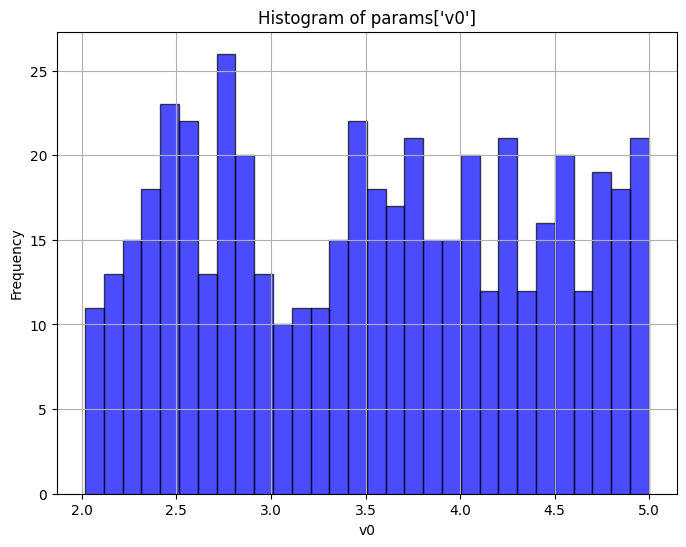

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(params['v0'].detach().numpy(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of params[\'v0\']')
plt.xlabel('v0')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# params['t_coll'] = torch.linspace(0, 5, steps=params['t_coll'].numel()).clone().detach().requires_grad_(True).view(-1, 1)


# # Shuffle the t_coll tensor
# shuffled_indices = torch.randperm(params['t_coll'].size(0))
# params['t_coll'] = params['t_coll'][shuffled_indices]

# # Ensure requires_grad=True
# params['t_coll'] = params['t_coll'].clone().detach().requires_grad_(True).view(-1, 1)

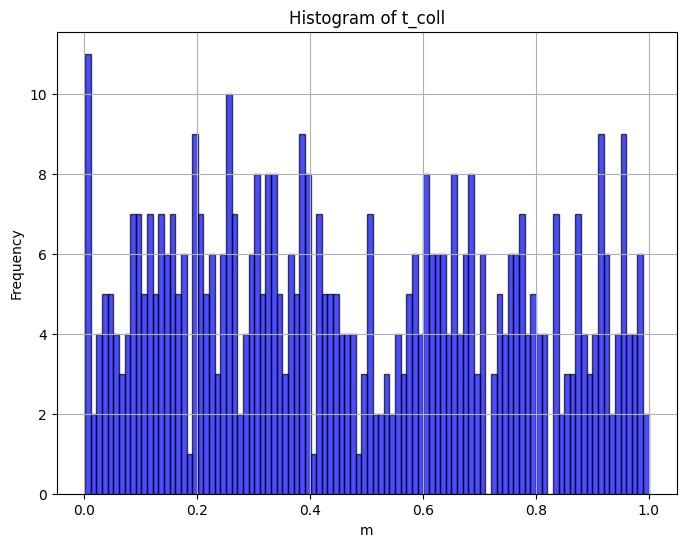

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(params['t_coll'].detach().numpy(), bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of t_coll')
plt.xlabel('m')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
print(params['norm_info'])

{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.1}, 'k': {'mean': 5.0, 'std': 0.5}}


Epoch 0, PDE loss: 0.39461803436279297, BC loss: 13.273017883300781


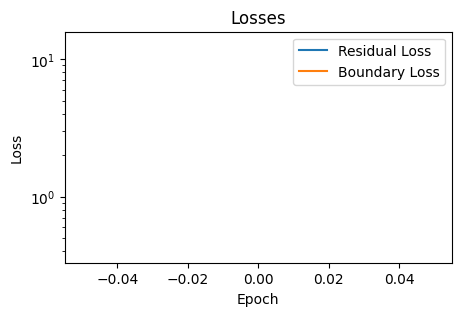

Epoch 1000, PDE loss: 0.2711052894592285, BC loss: 0.018722517415881157


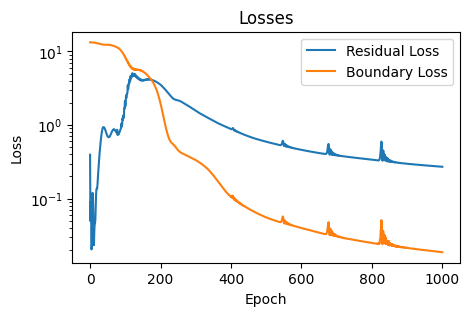

Epoch 2000, PDE loss: 0.12669223546981812, BC loss: 0.00823719147592783


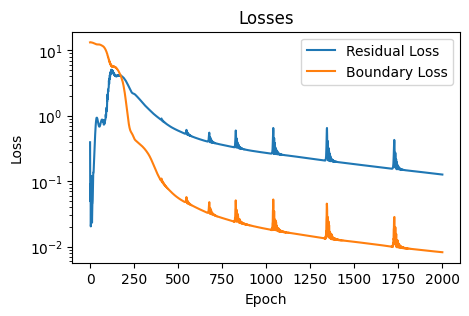

Epoch 3000, PDE loss: 0.050252530723810196, BC loss: 0.005222400650382042


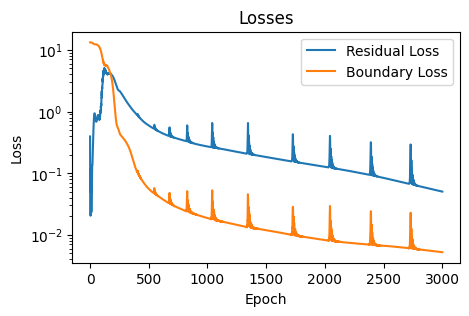

Epoch 4000, PDE loss: 0.020805032923817635, BC loss: 0.0030303841922432184


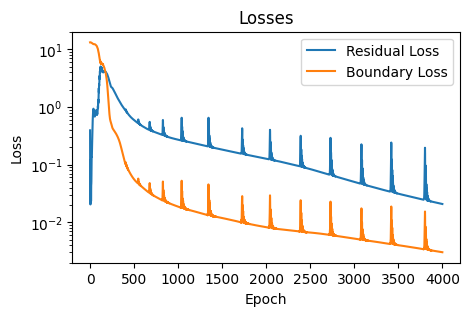

Epoch 5000, PDE loss: 0.00975949689745903, BC loss: 0.001656847889535129


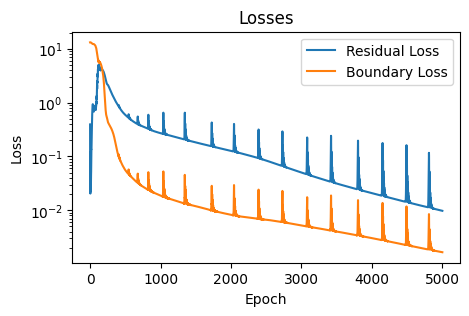

Epoch 6000, PDE loss: 0.005746066104620695, BC loss: 0.0010737280827015638


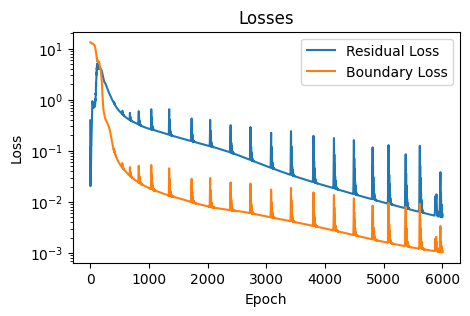

Epoch 7000, PDE loss: 0.002893897006288171, BC loss: 0.0007551524904556572


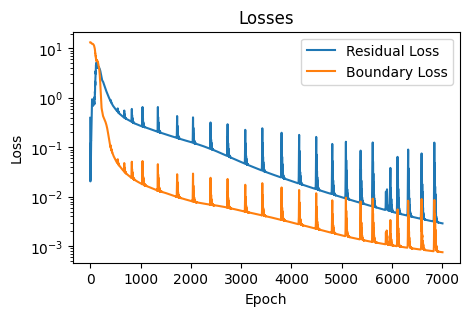

Epoch 8000, PDE loss: 0.018781868740916252, BC loss: 0.0026996831875294447


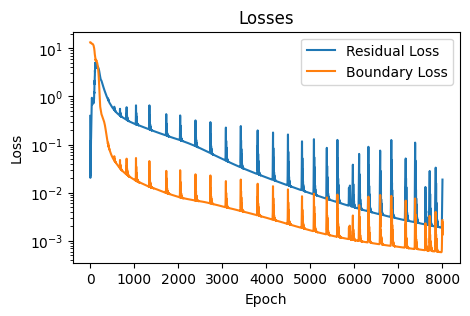

Epoch 9000, PDE loss: 0.0016860408941283822, BC loss: 0.0006556085427291691


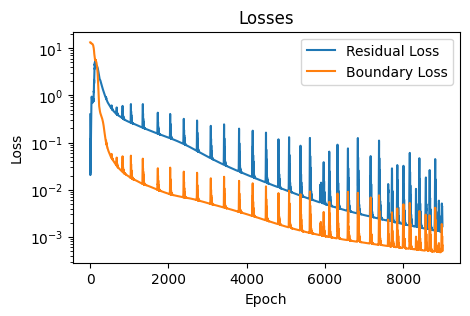

Phase 1 complete. Best loss so far: 0.001687818206846714
Improved loss found: 0.0016876831650733948 (after 7 extra epochs)


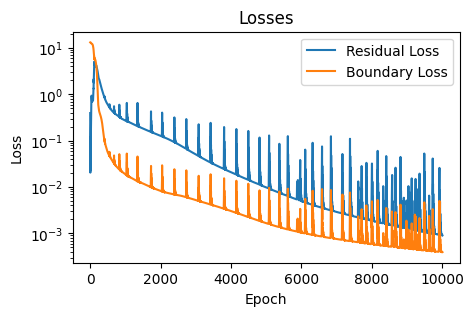

In [8]:
mass_mu_model = P2INN_oscillator()
optimizer = optim.Adam(mass_mu_model.parameters(), lr=0.001)
trainer = Trainer(mass_mu_model, optimizer,epochs=10000, lambda_bc=2.0)
trainer.train(params)

In [18]:
import os

# Save the model's state dictionary to the "Trained models" folder
model_path = "Trained models/TESTP2.pth"

if os.path.exists(model_path):
    response = input(f"The file '{model_path}' already exists. Do you want to replace it? (yes/no): ").strip().lower()
    if response != 'yes':
        print("Model saving aborted.")
    else:
        torch.save(mass_mu_model.state_dict(), model_path)
        print(f"Model's state dictionary saved to {model_path}")
else:
    torch.save(mass_mu_model.state_dict(), model_path)
    print(f"Model's state dictionary saved to {model_path}")

Model's state dictionary saved to Trained models/TESTP2.pth


In [ ]:
PINN_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)

# Load the saved state dictionary
checkpoint = torch.load("Trained models/m_mu_k_v0_500_norm_4001.pth")

# Filter out keys that do not match the current model architecture
filtered_state_dict = {k: v for k, v in checkpoint.items() if k in PINN_model.state_dict() and PINN_model.state_dict()[k].shape == v.shape}

# Load the filtered state dictionary
PINN_model.load_state_dict(filtered_state_dict, strict=False)

PINN_model.eval()

In [19]:
PINN_model = P2INN_oscillator()
# Load the saved state dictionary with weights_only=True
PINN_model.load_state_dict(torch.load("Trained models/" \
"TESTP2.pth"
, weights_only=True))
PINN_model.eval()

P2INN_oscillator(
  (param_encoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
  )
  (coord_encoder): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [20]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

In [21]:
# pick one test point (with normalized τ in [0,1] and your particular m, mu, v0)
τ_test = torch.tensor([[0.0]])       # or any τ you care about
m_test = torch.tensor([[ (m_mean-m_mean)/m_std ]])    # =0 if at mean, or e.g. +5
mu_test = torch.tensor([[ (mu_mean - mu_mean)/mu_std ]])
v0_test = torch.tensor([[ (4.0 - v0_mean)/v0_std ]])   # your test value
k_test  = torch.tensor([[0.0]])      # similarly z-scored if you normalized it
y0_test = torch.tensor([[0.0]])

# build the full input vector
x = torch.cat([τ_test, m_test, mu_test, k_test, y0_test, v0_test], dim=1)  # shape (1,6)

# grab the first Linear layer
lin0 = PINN_model.net[0]    # make sure this is your trained model

# compute z = W x + b
z = x @ lin0.weight.t() + lin0.bias  # shape (1,20)

print("pre-activations (z) stats:")
print("  min:", z.min().item())
print("  max:", z.max().item())
print("  mean:", z.mean().item())
print("  std:", z.std().item())

AttributeError: 'P2INN_oscillator' object has no attribute 'net'

In [22]:
def inspect_activations(model, x):
    """
    Feeds x through model.net and prints min/max pre-activations for each Linear layer.
    x should be shape (1,6).
    """
    activ = x
    layer_i = 0
    for layer in model.net:
        if isinstance(layer, nn.Linear):
            z = layer(activ)
            print(f"Layer {layer_i} pre-act:  min {z.min().item():.2f}, max {z.max().item():.2f}")
            activ = z
            layer_i += 1
        else:  # nn.Tanh (or any activation)
            activ = layer(activ)

# Reconstruct each input as a (1,1) Tensor
τ_test  = torch.tensor([[0.0]])  # normalized time = 0
m_z_val = (4.0 - m_mean) / m_std
mu_z_val = (mu_mean - mu_mean) / mu_std  # e.g. 0 at mean
k_z_val  = 0.0
y0_z_val = 0.0
v0_z_val = (4.0 - v0_mean) / v0_std

# Wrap each in a 1×1 Tensor
m_z   = torch.tensor([[m_z_val]],   dtype=torch.float32)
mu_z  = torch.tensor([[mu_z_val]],  dtype=torch.float32)
k_z   = torch.tensor([[k_z_val]],   dtype=torch.float32)
y0_z  = torch.tensor([[y0_z_val]],  dtype=torch.float32)
v0_z  = torch.tensor([[v0_z_val]],  dtype=torch.float32)

# Now concatenate along dim=1 to get shape (1,6)
x_test = torch.cat([τ_test, m_z, mu_z, k_z, y0_z, v0_z], dim=1)

# And inspect all layers’ pre‐activations:
inspect_activations(PINN_model, x_test)

AttributeError: 'P2INN_oscillator' object has no attribute 'net'

### Evaluating model performance

In [23]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

In [24]:
print(params.keys())
print(params['norm_info'])

dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.1}, 'k': {'mean': 5.0, 'std': 0.5}}


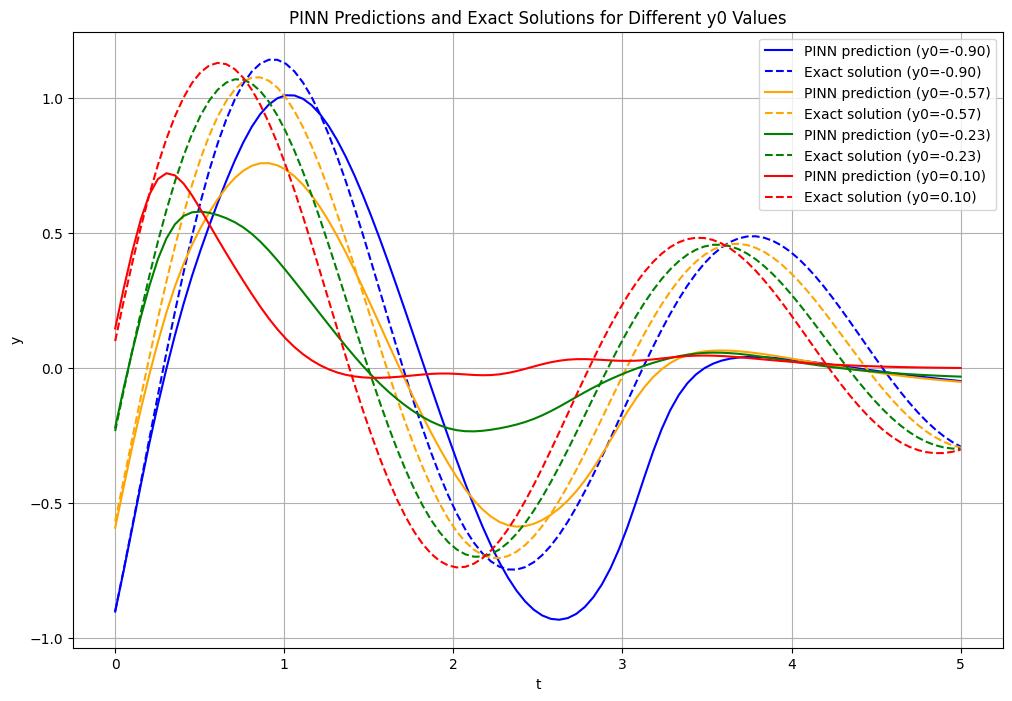

In [25]:
t_test = torch.linspace(0, 5, 100).view(-1, 1)
t_coll = t_test / specs['t']['range']

y0_values = np.linspace(y0_mean - 5 * y0_std, y0_mean + 5 * y0_std, 4)

plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for y0, color in zip(y0_values, colors):
    test_values = [m_mean, mu_mean, k_mean, y0, v0_mean]
    test_params = make_input_params(t_coll, test_values, params['norm_info'])
    y_pred = PINN_model(t_coll, *test_params)
    y_sol = damped_harmonic_oscillator(t_test.detach().numpy(), *test_values)

    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label=f'PINN prediction (y0={y0:.2f})', color=color)
    plt.plot(t_test.detach().numpy(), y_sol, linestyle='--', label=f'Exact solution (y0={y0:.2f})', color=color)

plt.legend()
plt.title('PINN Predictions and Exact Solutions for Different y0 Values')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

m, mu, k, y0 not norm
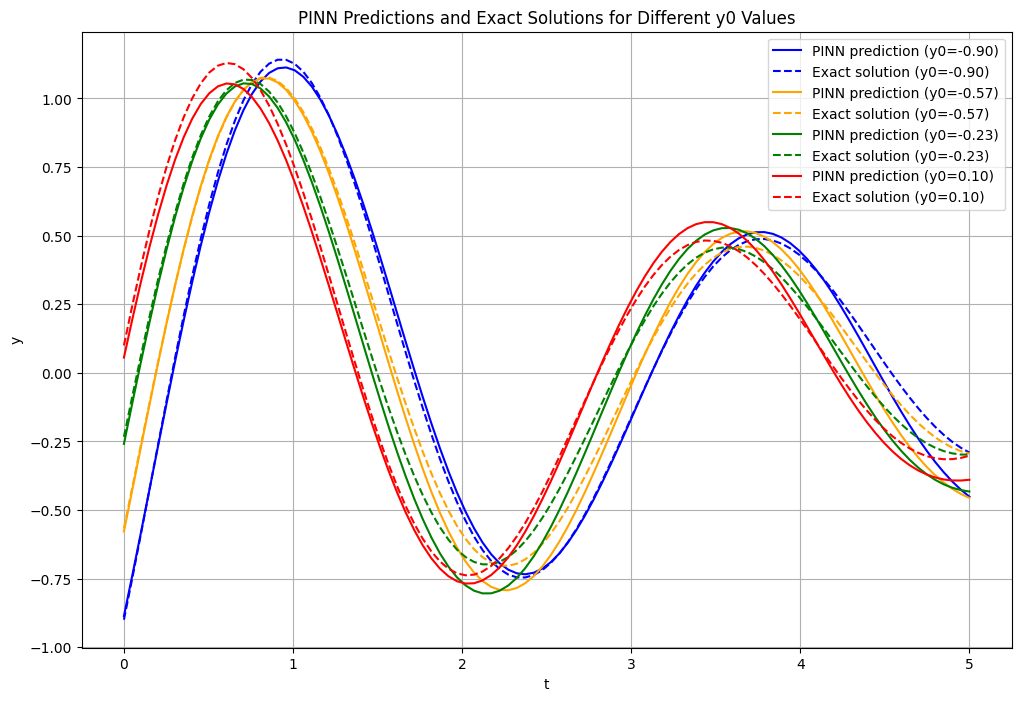


m_mu_y0_500_norm_4001
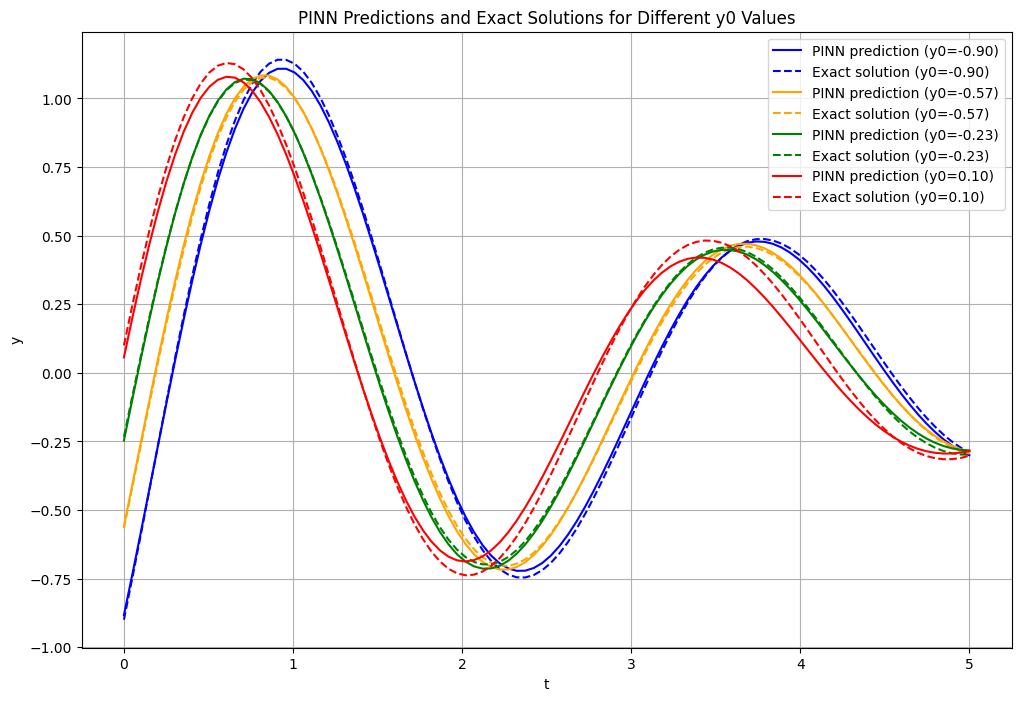

m_mu_k_y0_500_norm_4001
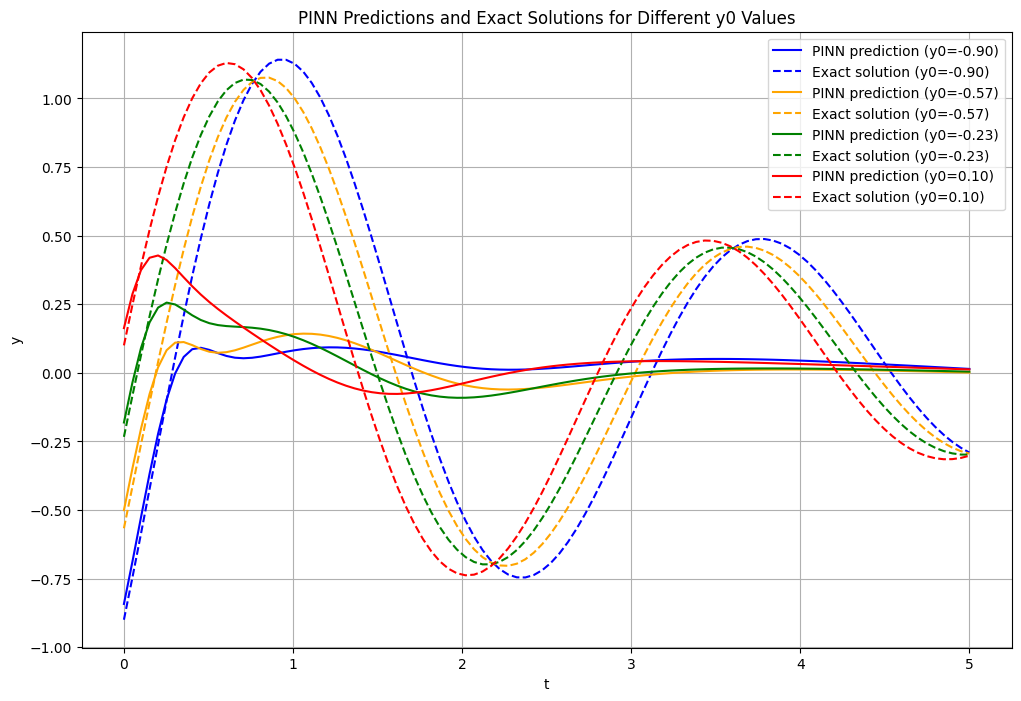

m_mu_k_y0_500_norm_notT_4001
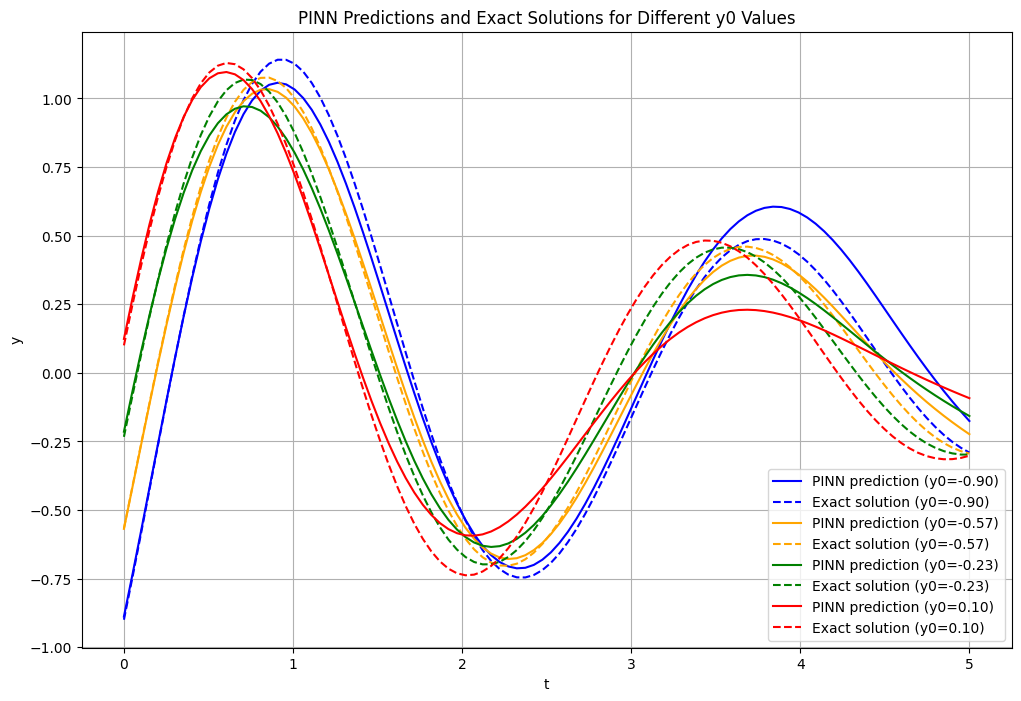

m_mu_k_y0_v0_500_norm_notT_4001
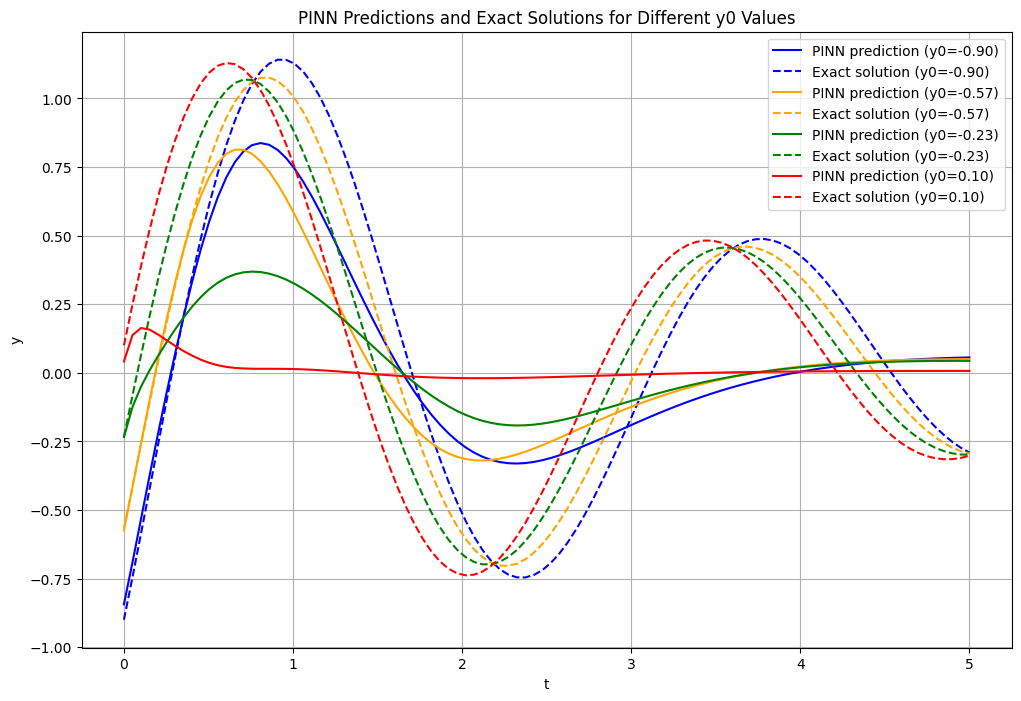

In [16]:
import itertools

m_values = np.linspace(m_mean - 2 * m_std, m_mean + 4 * m_std, 6)
mu_values = np.linspace(mu_mean - 4 * mu_std, mu_mean + 2 * mu_std, 6) 

errors = []
combos = list(itertools.product(m_values, mu_values))

for combo in combos:
    m_val_combo, mu_val_combo = combo

    test_values = [m_val_combo, mu_val_combo, k_mean, y0_mean, v0_mean]
    test_params = make_input_params(t_coll, test_values, params['norm_info'])
    
    # Get the PINN prediction
    y_pred = PINN_model(t_coll, *test_params)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         *test_values)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu)=({m_val_combo:.2f}, {mu_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")


Combined Mean Squared Error over all combinations: 0.157399


Combined Mean Squared Error over all combinations: 0.003413 - 4001

Combined Mean Squared Error over all combinations: 0.000672 - 8001

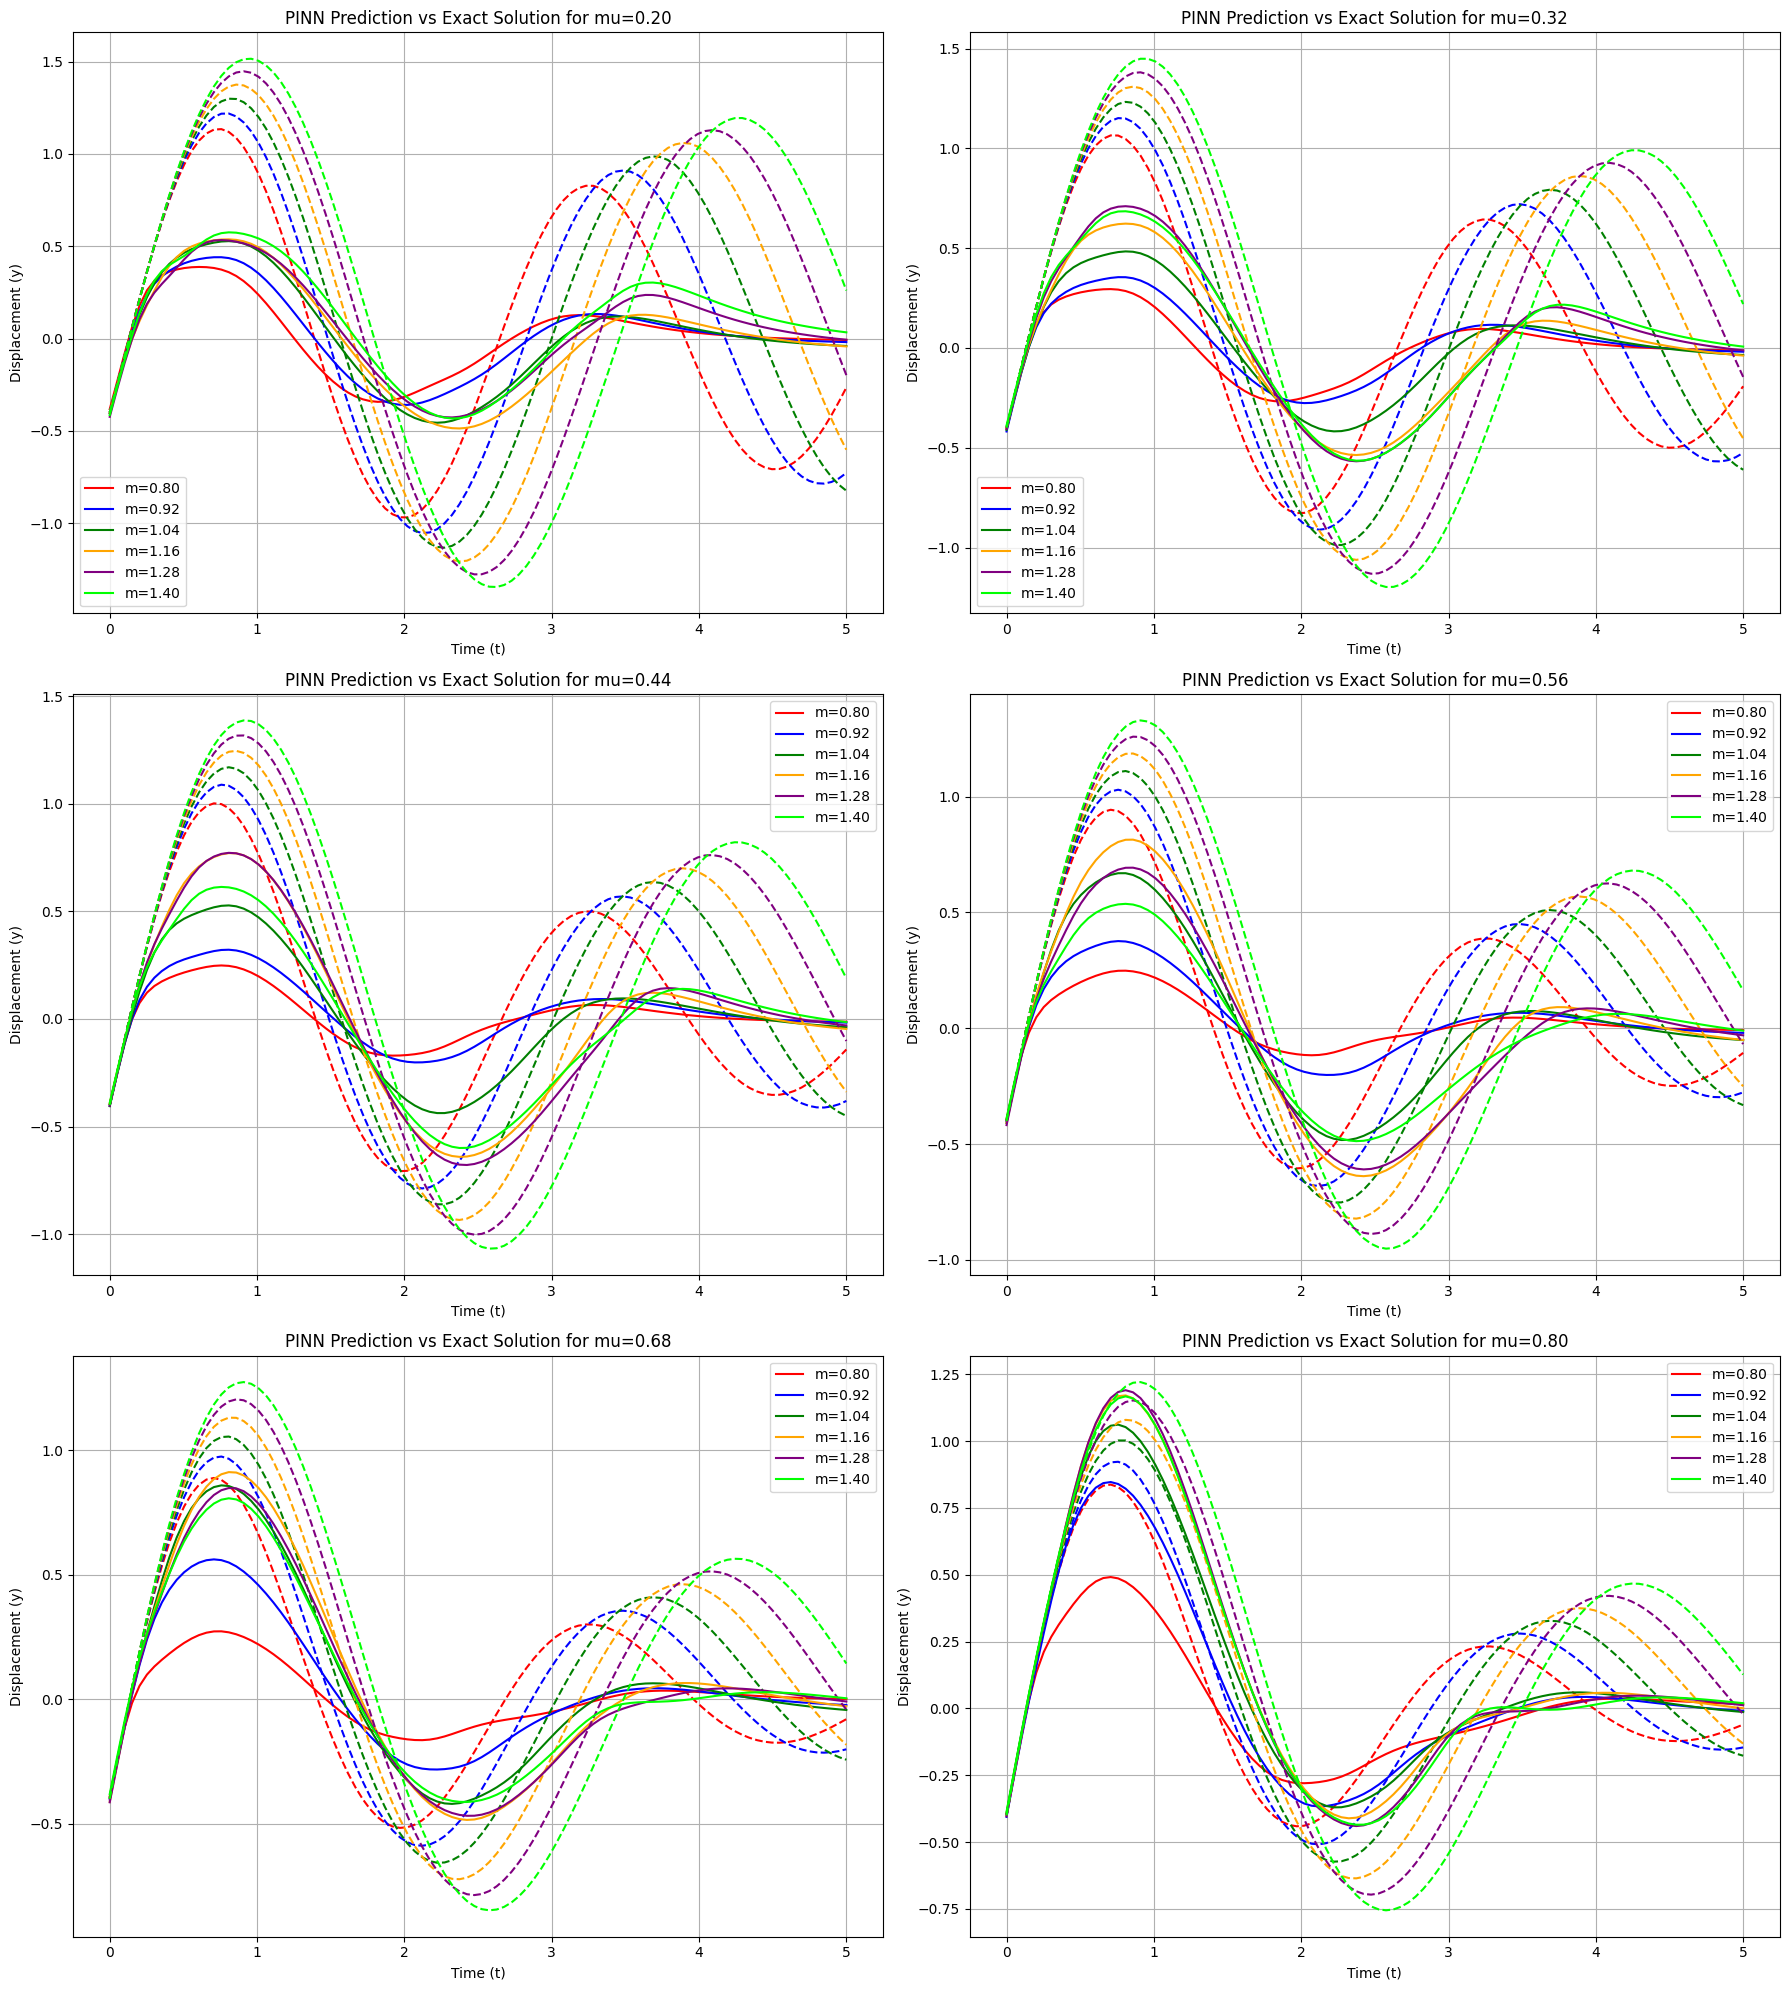

In [17]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes,mu_values):

    for idx, m in enumerate(m_values):
        test_values = [m, mu, k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_coll, test_values, params['norm_info'])
        
        # Get the PINN prediction
        y_pred = PINN_model(t_coll, *test_params)
        # Compute the exact solution using the provided function (convert t_test to numpy)
        y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                             *test_values)
        
        ax.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
        ax.plot(t_test.detach().numpy(), y_exact, color=colors[idx], linestyle='--')

    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

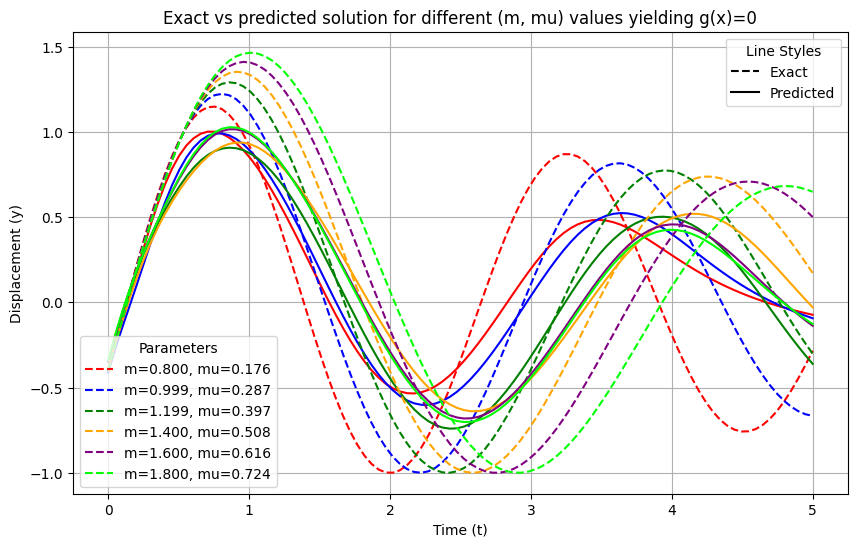


Combined Mean Squared Error over all 1000 combinations: 0.100243


In [17]:
# g(x) = 0.0 for exact solution

from scipy.optimize import root_scalar

# Function to find mu for a given m where the exact solution is -1.0
def find_mu_g_equal_0(t,m,k, y0, v0, mu_bracket=(0.0, 2.0)):
    # Define the objective: we want the minimum of the solution to be -1
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # When np.min(y_exact) == -1, this equals zero

    # Before starting, check that the bracket endpoints produce opposite signs
    a, b = mu_bracket
    if objective(a) * objective(b) > 0:
        raise ValueError("No sign change found in the objective function. Adjust mu_bracket values.")
    
    # Use the Brent's method (root_scalar with method='brentq') to find the root
    result = root_scalar(objective, bracket=mu_bracket, method='brentq')
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

# Find mu values for each m
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 1000)
mu_values = []
t_test = np.linspace(0, 5, 100)

for m in m_values:
    mu_values.append(find_mu_g_equal_0(t_test, m, k_mean, y0_mean, v0_mean))

# Filter mu_values (and corresponding m_values) in one go:
filtered = [(m, mu) for m, mu in zip(m_values, mu_values)
            if mu_mean - 8 * mu_std <= mu <= mu_mean + 2 * mu_std]

#Plott and compare the exact and predicted solutions for the filtered (m, mu) pairs
plt.figure(figsize=(10, 6))
idx=0
# Select five evenly distributed indices from the filtered list
selected_indices = np.linspace(0, len(filtered) - 1, 6, dtype=int)

for i in selected_indices:
    m, mu = filtered[i]
    color = colors[idx]  # Cycle through colors if idx exceeds length

    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    plt.plot(t_test, y_exact, label=f'm={m:.3f}, mu={mu:.3f}', linestyle='--', color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color)

    idx += 1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for different (m, mu) values yielding g(x)=0')
plt.legend(loc='lower left')
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='upper right', title='Line Styles')

plt.show()

errors = []
for m,mu in filtered:
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    mse = np.mean((y_pred.detach().numpy().flatten() - y_exact) ** 2)
    errors.append(mse)    
combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all {len(errors)} combinations: {combined_mse:.6f}")

### Adaptive sampling at g(x) = 0 

#### Sample new training points 

In [ ]:
# Generate latin hypercube samples

from scipy.stats import qmc

def generate_latin_hypercube_samples(specs, norm_info, num_samples=1000):
    """
    Generate Latin Hypercube samples for parameters in specs that also is in params['norm_info].

    returns:
        - samples: A numpy array with a coloumn for each parameter in specs. 
        The params that are in norm_info are sampled, and the rest are set to their mean value.
        - params_to_sample: A list of the parameters that were sampled.
    """ 
    # Extract the number of samples and the parameters to sample from specs
    params_to_sample = [param for param in specs.keys() if param in norm_info and param != 't']
    
    # Create a Latin Hypercube sampler
    sampler = qmc.LatinHypercube(len(params_to_sample))
    samples = sampler.random(num_samples)
    
    # Scale the samples to the ranges defined in specs
    scaled_samples = []
    i = 0
    for param in specs.keys():
        if param == 't':
            continue
        if param in params_to_sample:
            lower_bound = specs[param]['mean'] + specs[param]['lower_multiplier'] * specs[param]['std']
            upper_bound = specs[param]['mean'] + specs[param]['upper_multiplier'] * specs[param]['std']
            scaled_samples.append(qmc.scale(samples[:, i].reshape(-1, 1), lower_bound, upper_bound))
            i += 1
        else:
            # If the parameter is not in the specs, just use its mean value
            scaled_samples.append(np.full((num_samples, 1), specs[param]['mean']))
    return np.array(scaled_samples).T[0], params_to_sample

In [ ]:
# Evaluate g(x) and residual for each sample
def evaluate_G_and_residual(PINN_model, LHS_samples, t_coll, params,lambda_bc=2.0):

    t0_tensor =torch.zeros_like(t_coll).requires_grad_(True)
    G_values = []
    residual_values = []

    for i in range(len(LHS_samples)):
        row = LHS_samples[i]
        input_params = make_input_params(t_coll, row, params['norm_info'])

        # Ensure tensors require gradients
        m_tensor = input_params[0].requires_grad_(True)
        mu_tensor = input_params[1].requires_grad_(True)
        k_tensor = input_params[2].requires_grad_(True)
        y0_tensor = input_params[3].requires_grad_(True)
        v0_tensor = input_params[4].requires_grad_(True)
        
        # Evaluate the limit state function G(x) for each sample
        G_values.append(limit_state_function_G(PINN_model, t_coll, input_params, differentiable=False).item())

        # Compute the residual
        pde_residual = pde_loss(PINN_model, t_coll.requires_grad_(True), m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
        # Compute the boundary loss
        boundary_residual = boundary_loss(PINN_model, t0_tensor, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
        residual_values.append(pde_residual + lambda_bc * boundary_residual)

    # Convert to NumPy arrays for sampling
    # Not really needed, but for more versatile use it is better to have them in numpy format
    G_vals = np.array(G_values)
    residual_vals = np.array(residual_values)
    return G_vals, residual_vals

def sample_G_and_residual_points(G_vals, residual_vals, LHS_samples, alpha_g=20, alpha_residual=0.5, g_size=300, residual_size=200):
    # Sample near g(x) ≈ 0
    G_weights = np.exp(-alpha_g * np.abs(G_vals)) 
    G_weights /= np.sum(G_weights)  # Normalize weights
    G_indices = np.random.choice(len(LHS_samples), size=g_size, p=G_weights, replace=False)
    G_points_selected = LHS_samples[G_indices]

    # Sample near large residuals
    residual_weights = residual_vals**alpha_residual
    residual_weights /= np.sum(residual_weights)  # Normalize weights
    residual_indices = np.random.choice(len(LHS_samples), size=residual_size, p=residual_weights, replace=False)
    residual_points_selected = LHS_samples[residual_indices]
    # stack residual and G points
    points_selected = np.vstack((G_points_selected, residual_points_selected))
    return points_selected, G_points_selected, residual_points_selected

How the paper (Importance Sampling for PINNs) actually chooses points After identifying interesting regions (via DWT or another metric), the actual point selection is done using a weighted probability distribution over the sample pool: “We compute the sampling probability for each point using a normalized score... and sample points with probability proportional to that score.” Importance sampling for… In other words: Start with a pool of points (e.g. from LHS or uniformly sampled). Assign each point a score, like: Residual (if training a PINN), Gradient magnitude, Or your custom criterion (e.g. 𝜙(𝑥)=exp(−𝛼∣𝑔(𝑥)∣), to favor points near 𝑔=0).


In [ ]:
# import numpy as np

# def sample_time_points(T, N, r):
#     """
#     Sample N time points from a truncated exponential distribution over [0, T].

#     Parameters:
#     - T: Total time duration.
#     - N: Number of time points to sample.
#     - r: Rate parameter of the exponential distribution.

#     Returns:
#     - Array of sampled time points.
#     """
#     if r == 0:
#         # Uniform sampling
#         return np.linspace(0, T, N)
#     else:
#         # Inverse transform sampling
#         u = np.random.uniform(0, 1, N)
#         return -np.log(1 - u * (1 - np.exp(-r * T))) / r

# https://arxiv.org/abs/2404.18780

In [ ]:
# Generate samples
num_samples = 10000

LHS_samples, sampled_params = generate_latin_hypercube_samples(specs, params['norm_info'], num_samples)

In [ ]:
G_vals, residual_vals = evaluate_G_and_residual(PINN_model, LHS_samples, t_coll, params, lambda_bc=2.0)

In [ ]:
points_selected, G_points_selected, residual_points_selected = sample_G_and_residual_points(G_vals, residual_vals, LHS_samples, alpha_g=20, alpha_residual=0.5, g_size=300, residual_size=200)

Do I really need the residual here? I would have to try both, and see if adding high residual points actually helps. 

Also, I have not implemented a k_mean algorithm yet, since The points chosen looked quite wdespread already. Maybe I would need it if I use residual adaptive sampling with a high number for residul_vals**(Number). 

In [ ]:
# Extract the first, second, and last columns of residual_points_selected for plotting
x_residual = residual_points_selected[:, 0]  # First column
y_residual = residual_points_selected[:, 1]  # Second column
z_residual = residual_points_selected[:, -2]  # Last column

# Extract the first, second, and last columns of G_points_selected for plotting
x_g = G_points_selected[:, 0]  # First column
y_g = G_points_selected[:, 1]  # Second column
z_g = G_points_selected[:, -2]  # Last column

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot residual_points_selected
scatter_residual = ax.scatter(x_residual, y_residual, z_residual, c=z_residual, cmap='viridis', label='Residual Points')

# Plot G_points_selected
scatter_g = ax.scatter(x_g, y_g, z_g, c='red', label='G Points', alpha=0.8)

# Add color bar for residual points
cbar = plt.colorbar(scatter_residual, ax=ax, pad=0.1)
cbar.set_label('Last Column Values (Residual Points)')

# Set labels and title
ax.set_title('3D Scatter Plot of Residual and G Points')
ax.set_xlabel('x (First Column)')
ax.set_ylabel('y (Second Column)')
ax.set_zlabel('z (Last Column)')

# Adjust the viewing angle
ax.view_init(elev=0, azim=0)  # Change elevation and azimuth for a new angle

ax.legend()
plt.show()

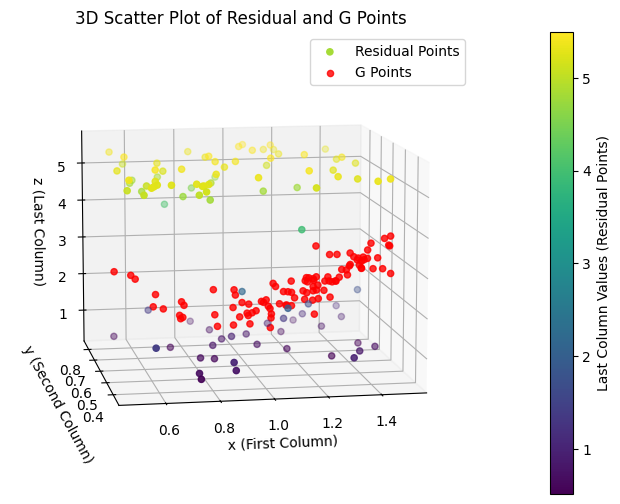
This piqture is good. It shows how it could be smart to narrow down the std search for paramter values. Here, sampling from v0 larger than 4 is not really necessary, since all the red points are below that. How do I implement that?

This adaptive refinement of paraeter space should be implemented, and this also goes for the physical space, and in my case time. No need to TRAIN THE pinn AFTER T=4 sek, but this is another impelemntation. 

In [ ]:
plt.figure(figsize=(12, 6))
# Plot g_weights
plt.subplot(1, 2, 1)
plt.plot(G_weights[:20], 'o', label='g_weights', color='blue')
plt.title('g_weights')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.grid(True)
plt.legend()

# Plot g_vals
plt.subplot(1, 2, 2)
plt.plot(-abs(G_vals[:20]), 'o-', label='g_vals', color='orange')
plt.title('g_vals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Next training round 


In [ ]:
optimizer = optim.Adam(PINN_model.parameters(), lr=0.001)
trainer = Trainer(PINN_model, optimizer,epochs=4001)
trainer.train(points_selected)

### Finding MPP with scipy.optimize minimize

In [ ]:
from scipy.optimize import minimize
def MPP_objective(x,model,t, values, lambda_penalty, norm_info):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    all_values = list(x) + values
    pred_params = make_input_params(t, all_values, norm_info)
    lsf = limit_state_function_G(model, t, pred_params, differentiable=False)
    deviation=0
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            deviation+=(abs(x[i] - specs[param]['mean']) / specs[param]['std'])
    penalty = lambda_penalty * deviation

    return (abs(lsf) + penalty).item()
    
def find_MPP(model, t, values, norm_info, lamdba_penalty = 0.001):
    """
    Find the most probable point (MPP) using optimization.
    """
    MPP=[]
    x = []
    other_values = []
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            x.append(values[i])
        else:
            other_values.append(values[i])
    res = minimize(
        MPP_objective, 
        x, 
        args=(model, t, other_values, lamdba_penalty, norm_info), 
        method='Nelder-Mead'
        )
    if res.success:
        MPP.append(res.x)
    else:
        print(f"Start {i}: Optimization did not converge from initial guess {x}")
    return MPP

### Could also use jac and utlize autograd for the gradient
# def gradient(x, *args):
#     # must return a 1D array with same length as x
#     return ...


MPP_start = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

MPP = find_MPP(PINN_model, t_coll, MPP_start, params['norm_info'], lamdba_penalty=0.00001)
print(f"MPP: {MPP}")

#### Visualizing

In [ ]:
#Visualization of the MPP
mass_vals = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = MPP_objective([Mass[i, j], Mu[i, j]], PINN_model, t_coll, [k_mean, y0_mean, v0_mean],
                                        lambda_penalty=0.0, norm_info=params['norm_info'])

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
# plt.scatter([pt[0] for pt in MPP[0]], [pt[1] for pt in MPP[0]],
#             color='red', label='MPP')
plt.scatter(MPP[0][0].item() , MPP[0][1].item(), color='lime', label='Scipy minimize MPP', edgecolor='black')
plt.scatter(m_mean, mu_mean, color='red', label='Mean', edgecolor='black')
plt.legend()
plt.title('Objective Function Contour Plot')
plt.xlabel('Mass (m)')
plt.ylabel('Damping Ratio (mu)')
plt.grid()
plt.show()

### MPP brute force

#### PINN_model

In [ ]:
def normal_pdf(x, mean, std):
    """Compute 1D normal PDF."""
    return 1.0/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2)

num_points = 200  # Increase if you need a finer grid

m_vals = np.linspace(m_mean +2*m_std, m_mean + 4*m_std, num_points)
mu_vals = np.linspace(mu_mean - 4*mu_std, mu_mean -2*mu_std , num_points)

m_grid, mu_grid = np.meshgrid(m_vals, mu_vals)

# Time vector for evaluating the solution
n_t = 1000
t_grid = torch.linspace(0, 1, n_t).view(-1, 1)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.0001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        test_values = [m_grid[j, i], mu_grid[j, i], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_grid, test_values, params['norm_info'])
        g_val = limit_state_function_G(PINN_model,t_grid, test_params, differentiable=False).item()
        G[j, i] = np.nan if g_val is None else g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = test_values[0]
                best_mu = test_values[1]
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.6f}\n"
          f"  mu = {best_mu:.6f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.310553
  mu = 0.464322
  g  = 0.000044   (should be close to 0)
  Joint PDF = 6.451544e-03

#### Analytical function

In [ ]:
# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu, k=5.0, y0=-0.4, v0=3.0).min() +1
        G[j, i] = g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = m
                best_mu = mu
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.4f}\n"
          f"  mu = {best_mu:.4f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3106
  mu = 0.4601
  g  = 0.000997   (should be close to 0)
  Joint PDF = 5.107185e-03

### FORM

In [ ]:
# Step 0: initialize u (standard normal variables)
u = torch.tensor([0.0] * (len(params['norm_info'])-1), dtype=torch.float32, requires_grad=True) # '-1' because 't' is also in norm_info

for i in range(100):
    # Step 1: __________________________________
    values = []
    for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            values.append(u[j])
        else:
            values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

    t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
    input_params = tuple(v.expand(len(t_FORM), 1) for v in values)


    LSF= limit_state_function_G(PINN_model,t_FORM, input_params,differentiable=False)
    LSF.backward()

    # Extract gradient w.r.t. u
    grad_u = u.grad.detach().clone()  # ∇G/∇u
    norm_grad = torch.norm(grad_u)

    # Step 4: Compute update
    beta = LSF.item() / norm_grad.item()
    u_next = -beta * (grad_u / norm_grad)

    # Manually update u (we do it outside optimizer.step() to follow HL-RF logic)
    with torch.no_grad():
        u.copy_(u+u_next*0.2)
        # damping_factor = 0.6
        # u.copy_(u + damping_factor * (u_next - u))


    formatted_u_next = [f"{val:.4f}" for val in u_next.tolist()]
    formatted_u = [f"{val:.4f}" for val in u.tolist()]
    
    print(f'beta = {beta:.4f}')
    formatted_grad_u = [f"{val:.4f}" for val in grad_u.tolist()]
    print(f'grad_u = {formatted_grad_u}')
    print(f'norm_grad = {norm_grad:.4f}')
    print(f'LSF = {LSF.item()}')
    print(f'u_next = {formatted_u_next}')
    print(f'u = {formatted_u}')
    print('\n')
    u.grad.zero_()
    
print(f"∇G = {grad_u.tolist()}, ‖∇G‖ = {norm_grad:.4f}, β = {beta:.4f}")

beta = 0.0000
grad_u = ['-0.0565', '0.0496']
norm_grad = 0.0752
LSF = 0.0
u_next = ['0.0000', '-0.0000']
u = ['3.2879', '-2.5062']

In [ ]:
epsilon = 1e-3
finite_diff =[]
autograd_grad = []

start=-3
end=9
mu_test = 0

for i in np.linspace(start, end, 100):
    u_val = torch.tensor([i, mu_test], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(model, u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(model,t_FORM, input_params, differentiable=True)

    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()

    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

# Extract the first element of each list in finite_diff
finite_diff_first_elements = [fd[0] for fd in finite_diff]
# Extract the first element of each list in autograd_grad
autograd_grad_first_elements = [ag[0] for ag in autograd_grad]

# Plot the first element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_first_elements, label='Finite Difference (First Element)', color='blue')
plt.plot(np.linspace(start, end, 100), autograd_grad_first_elements, label='Autograd Gradient (First Element)', color='red', linestyle='--')
plt.xlabel('m')
plt.ylabel('Finite Difference (m)')
plt.title(f'dG/dm for mu = {mu_test} vs m')
plt.legend()
plt.grid()
plt.show()

finite_diff =[]
autograd_grad = []
norm_grad_list = []

start=-9
end=3
m_test = 0
for i in np.linspace(start, end, 100):
    u_val = torch.tensor([m_test, i], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)
    
    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()
    norm_grad = torch.norm(grad_u)
    norm_grad_list.append(norm_grad.item())
    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

finite_diff_second_elements = [fd[1] for fd in finite_diff]
autograd_grad_second_elements = [ag[1] for ag in autograd_grad]
print(norm_grad_list)
# Plot the second element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_second_elements, label='Finite Difference (Second Element)', color='green')
plt.plot(np.linspace(start, end, 100), autograd_grad_second_elements, label='Autograd Gradient (Second Element)', color='orange', linestyle='--')
plt.xlabel('mu')
plt.ylabel('Finite Difference (mu)')
plt.title(f'dG/dmu for m = {m_test} vs mu')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 1. Wrap u again to ensure it's a fresh, tracked variable
u_FORM = u.detach().clone().requires_grad_(True)

# 2. Rebuild `values` list using u_final
values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        values.append(u_FORM[j])  # Adjusted for the damping factor
    else:
        values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# 3. Expand to match t
input_params = tuple(v.expand(len(t_FORM), 1) for v in values)

# 4. Re-evaluate G
G_final = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False)
print("Final G at converged u:", G_final)

In [ ]:
y_pred = PINN_model(t_FORM, *input_params)

plt.figure(figsize=(10, 6))
plt.plot(t_FORM, y_pred.detach().numpy(), label='PINN prediction')
# plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
########### MPP found ############
# Scypi minimize Model
m_mpp_model, mu_mpp_model = 1.25385061, 0.44097408
u1_mpp_model_scypi = (m_mpp_model - m_mean) / m_std
u2_mpp_model_scypi = (mu_mpp_model - mu_mean) / mu_std

# analytical brute force
m_mpp, mu_mpp = 1.3055,0.4573
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

# Model brute force 
m_mpp_model, mu_mpp_model = 1.296482, 0.465829
u1_mpp_model = (m_mpp_model - m_mean) / m_std
u2_mpp_model = (mu_mpp_model - mu_mean) / mu_std

print(((u_FORM[0]**2 + u_FORM[1]**2)**0.5).item())
print((u1_mpp_model_scypi**2+u2_mpp_model_scypi**2)**0.5)
print((u1_mpp**2+u2_mpp**2)**0.5)
print((u1_mpp_model**2+u2_mpp_model**2)**0.5)

In [ ]:
Num=10000000
t_test = np.linspace(2, 3, 200)
# Uncertainty in input parameters
m_samples = np.random.normal(1, 0.1, Num)
mu_samples = np.random.normal(0.6, 0.05, Num)
count = 0 
for i in range(Num):
    # Generate random samples for m and mu
    m_sample = m_samples[i]
    mu_sample = mu_samples[i]
    
    g= damped_harmonic_oscillator(t_test, m_sample,mu_sample).min() + 1.0  # Exact solution for g(x) = 0
    if g<0:
        count+=1

print(count/Num)

### Plotting the MPPs

In [ ]:
# Convert u → physical space x
t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
t_test  = torch.linspace(0, 5, 1000).view(-1, 1)
physical_values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        physical_values.append(z_score_denormalize(u[j], params['norm_info'][param]))
    else:
        physical_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# Define the grid for m and mu
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean +2 * mu_std, 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)
g_values_exact = np.full(m_grid.shape, np.nan)


for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        test_values = [m_grid[i, j], mu_grid[i, j], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_FORM, test_values, params['norm_info'])
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, test_params,differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *test_values).min() + 1.0  # Exact solution for g(x) = 0
        # Add a contour line at g = 0

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.plot(params['norm_info']['m']['mean'], params['norm_info']['mu']['mean'], 'bo', label='Point mean')
plt.plot(physical_values[0].item(), physical_values[1].item(), 'ro', label='FORM point')
plt.plot(m_mpp, mu_mpp, 'o', color='lime', label='MPP analytical brute force')  
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.show()

In [ ]:
# Define the grid for m and mu
m_values_norm = (m_values - m_mean) / m_std
mu_values_norm = (mu_values - mu_mean) / mu_std
m_grid, mu_grid = np.meshgrid(m_values_norm, mu_values_norm)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        grid_values = []
        grid_values_physical = []
        for k, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            u_grid=torch.tensor([m_grid[i, j], mu_grid[i, j]], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
            if param in params['norm_info']:
                grid_values.append(u_grid[k])
                grid_values_physical.append(z_score_denormalize(u_grid[k], params['norm_info'][param]).detach().numpy().item())
            else:
                grid_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        # 3. Expand to match t
        input_params = tuple(v.expand(len(t_FORM), 1) for v in grid_values)
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *grid_values_physical).min() + 1.0
        # Add a contour line at g = 0

In [ ]:
# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=50, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.plot(0, 0, 'ro', label='Point mean')
plt.plot(u[0].detach().numpy(),u[1].detach().numpy() , 'ro', label='FORM point')
plt.scatter(u1_mpp,u2_mpp, color='lime', edgecolor='black',  label='MPP analytical brute force')
plt.scatter(u1_mpp_model,u2_mpp_model, color='blue', edgecolor='black', label='MPP model brute force')
plt.scatter(u1_mpp_model_scypi,u2_mpp_model_scypi, color='orange', edgecolor='black', label='MPP scipy minimize')
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid()
plt.axis('equal')
plt.show()